In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys


def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '/home/jovyan/Gonads/Monkey_Zhao/figures/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
backcall            0.2.0
cairo               1.20.0
cffi                1.14.5
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.2
numpy               1.19.5
packaging           20.9
pandas              1.2.2
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.16
psutil      

'/home/jovyan/my-conda-envs/scanpy_env/bin/python'

In [2]:
from scanpy import logging as logg
from scanpy.neighbors import neighbors
from anndata import AnnData
from scipy.sparse import csc_matrix
import numpy as np


def woublet(
        adata,
        sim_doublet_ratio=2,
        n_neighbors=30,
        expected_doublet_rate=0.1,
        total_counts_key = 'n_counts',
        copy=False):
    """ Method for detecting mixed-celltype doublets. More documentation coming. In the meantime, email Sam Wolock with questions: swolock@g.harvard.edu
    adata: scanpy AnnData data matrix
    sim_doublet_ratio: number of doublets to simulate, relative to the number of observed transcriptomes (=adata.X.shape[0])
    n_neighbors: number of neighbors used in the k-nearest-neighbor classifier
    expected_doublet_rate: expected frequency of doublets. If unknown, a reasonable guess is 0.05. This parameter rescales the doublet scores but does not affect their ordering.
    total_counts_key: name of the field in adata.obs that contains total counts per cell, used for weighting a cell's relative contribution to simulated doublets. If not present, all cells are weighted equally.
    """
    adata = adata.copy() if copy else adata

    if 'X_pca' not in adata.obsm_keys():
        raise ValueError(
            'Did not find \'X_pca\'. Run `sc.pp.pca` first.')

    if total_counts_key in adata.obs:
        total_counts = np.array(adata.obs[total_counts_key])
    else:
        total_counts = np.ones(adata.X.shape[0])

    # Simulate doublets by averaging PC coordinates of random cell pairs
    logg.info('Simulating doublets')
    PCdat, doub_labels, parent_ix = simulate_doublets_from_pca(adata.obsm['X_pca'], 
        total_counts=total_counts, 
        sim_doublet_ratio=sim_doublet_ratio)


    adata_doub = AnnData(csc_matrix((PCdat.shape[0], 1)))
    adata_doub.obsm['X_pca'] = PCdat

    # Calculate doublet scores using k-nearest-neighbor classifier
    logg.info('Running KNN classifier')
    adata.obs['doublet_score'], adata.uns['sim_doublet_score'] = calculate_doublet_scores(
        adata_doub, 
        doub_labels, 
        n_neighbors=n_neighbors, 
        expected_doublet_rate = expected_doublet_rate)

    adata.obs['doublet_score']

    return adata if copy else None



#========================================================================================#

def simulate_doublets_from_pca(PCdat, total_counts=[], sim_doublet_ratio=1):
    '''
    Simulate doublets by averaging PCA coordinates of random cell pairs.
    Average is weighted by total counts of each parent cell, if provided.

    Returns:
    PCdoub (matrix of size (num_cells+num_sim_doubs, num_pcs)): PCA matrix with the simulated doublet PCA coordinates appended to the original data matrix PCdat.
    doub_labels (array of size (num_cells+num_sim_doubs)): 0 if observed cell, 1 if simulated doublet
    pair_ix (matrix of size(num_sim_doubs, 2)): each row gives the indices of the parent cells used to generate the simulated doublet
    '''

    n_obs = PCdat.shape[0]
    n_doub = int(n_obs * sim_doublet_ratio)

    if len(total_counts) == 0:
        total_counts = np.ones(n_obs)

    pair_ix = np.random.randint(0, n_obs, size=(n_doub, 2))

    pair_tots = np.hstack((total_counts[pair_ix[:, 0]][:,None], total_counts[pair_ix[:, 1]][:,None]))
    pair_tots = np.array(pair_tots, dtype=float)
    pair_fracs = pair_tots / np.sum(pair_tots, axis=1)[:,None]

    PCdoub = PCdat[pair_ix[:, 0],:] * pair_fracs[:, 0][:,None] + PCdat[pair_ix[:, 1],:] * pair_fracs[:, 1][:,None]

    PCdoub = np.vstack((PCdat, PCdoub))
    doub_labels = np.concatenate((np.zeros(n_obs), np.ones(n_doub)))

    return PCdoub, doub_labels, pair_ix

#========================================================================================#

def calculate_doublet_scores(adata, doub_labels, n_neighbors=30, expected_doublet_rate = 1.0):
    n_obs = sum(doub_labels == 0)
    n_sim = sum(doub_labels == 1)

    # Adjust k (number of nearest neighbors) based on the ratio of simulated to observed cells
    k_adj = int(round(n_neighbors * (1+n_sim/float(n_obs))))

    # Find k_adj nearest neighbors
    neighbors(adata, n_neighbors = k_adj, use_rep = 'X_pca')

    # Calculate doublet score based on ratio of simulated cell neighbors vs. observed cell neighbors
    matrix = adata.obsp['distances']
    n_sim_neigh = (matrix[:,doub_labels == 1]>0).sum(1).A.squeeze()
    n_obs_neigh = (matrix[:,doub_labels == 0]>0).sum(1).A.squeeze()
    
    doub_score = n_sim_neigh / (n_sim_neigh + n_obs_neigh * n_sim / float(n_obs) / expected_doublet_rate)
    doub_score_obs = doub_score[doub_labels == 0]

    # return doublet scores for observed cells and simulated cells
    return doub_score[doub_labels == 0], doub_score[doub_labels == 1]

In [ ]:
adata = sc.read('/nfs/team292/vl6/Monkey_Zhao/preprocessing.h5ad')
adata

In [ ]:
# Estimate doublet scoper per sample and set to 0
holder = np.zeros((adata.shape[0],))
for smp in np.unique(adata.obs['stage']):
    print(smp)
    adata_smp = adata[adata.obs['stage']==smp]
    sc.tl.pca(adata_smp)
    woublet(adata_smp)
    holder[adata.obs['stage']==smp] = adata_smp.obs['doublet_score']
adata.obs['doublet_score'] = holder

In [ ]:
# Check doublets distribution
adata.obs['doublet_score_0.75'] = adata.obs['doublet_score'] > 0.75

In [ ]:
sc.pl.umap(adata, color = ['doublet_score', 'doublet_score_0.75'], color_map = 'OrRd')

In [ ]:
adata = adata[~adata.obs['doublet_score_0.75'], :]
adata

#### Save data

In [15]:
adata.write('/nfs/team292/vl6/Monkey_Zhao/preprocessing_postDoublets.h5ad')

In [5]:
adata = sc.read('/nfs/team292/vl6/Monkey_Zhao/preprocessing_postDoublets.h5ad')
adata

AnnData object with n_obs × n_vars = 12308 × 15078
    obs: 'stage', 'percent_mito', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'doublet_score_0.75'
    var: 'monkey_ENSEMBL', 'human_ENSEMBL', 'human_gene_ortholog', 'monkey_gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'neighbors', 'pca', 'phase_colors', 'stage_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

#### Assign cell types to monkey data according to marker genes provided in the paper

In [6]:
# Extract PCA matrix and batch array
n_pcs = 20
pca = adata.obsm['X_pca'][:, 0:(n_pcs)]
batch = adata.obs['stage']

In [7]:
# Batch-correct the PCA using HARMONY method
%load_ext rpy2.ipython

In [8]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)
set.seed(1000)
hem <- HarmonyMatrix(pca, batch, theta=0, do_pca=FALSE, verbose = FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp



In [9]:
# Add harmony values to the anndata object
adata.obsm['X_pca'] = hem.values

In [10]:
# Visualize
sc.pp.neighbors(adata, n_pcs = n_pcs, random_state= 123)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:25)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


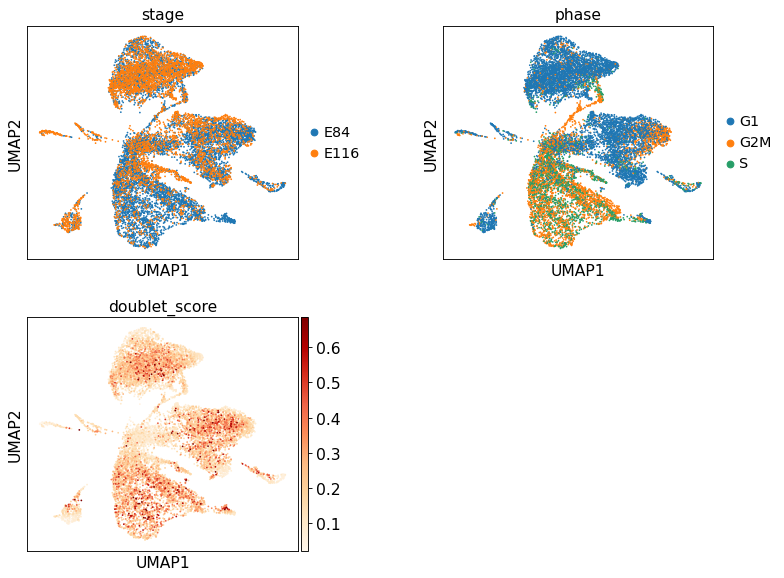

In [11]:
sc.pl.umap(adata, color = ['stage', 'phase', 'doublet_score'], color_map = 'OrRd', ncols = 2, wspace = 0.4)

Cluster the manifold

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


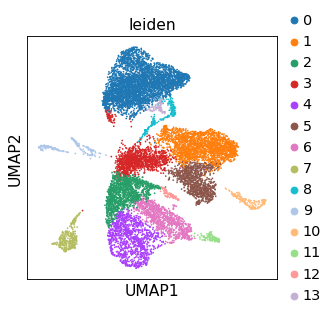

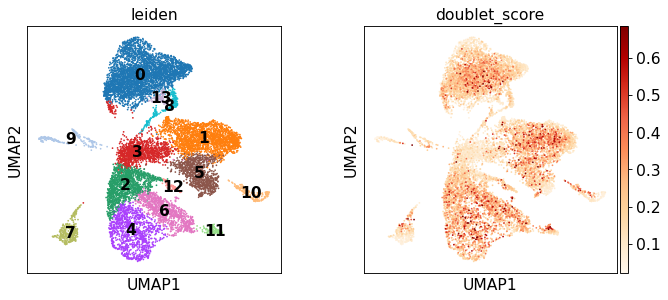

In [12]:
sc.tl.leiden(adata, resolution=0.4, random_state = 123)
sc.pl.umap(adata, color='leiden',save='_clustering.pdf')
sc.pl.umap(adata, color=['leiden', 'doublet_score'], color_map = 'OrRd',legend_loc='on data',save='_clustering_clusnumbers.pdf')

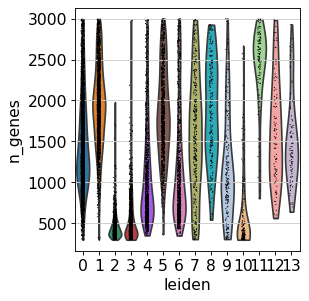

In [13]:
sc.pl.violin(adata, keys = ['n_genes'], groupby = 'leiden')

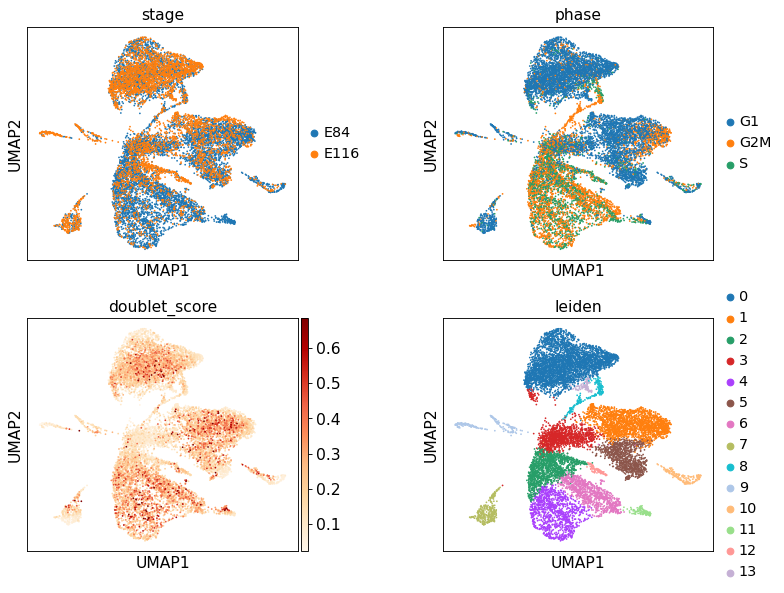

In [14]:
sc.pl.umap(adata, color = ['stage', 'phase', 'doublet_score', 'leiden'], color_map = 'OrRd', ncols = 2, wspace = 0.4)

In [16]:
###### From the excel file take the top 5 genes per cluster they define in the paper  
marker_genes = pd.read_excel('/nfs/team292/vl6/Monkey_Zhao/41421_2020_219_MOESM3_ESM.xlsx')
marker_genes.head()

,gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster
0,ENSMFAG00000004232,0.0,2.333151,0.968,0.029,0.0,1
1,ENSMFAG00000026088,0.0,1.740242,0.931,0.068,0.0,1
2,GIP,0.0,1.597363,0.924,0.023,0.0,1
3,DPPA4,0.0,1.329533,0.935,0.054,0.0,1
4,ENSMFAG00000037727,0.0,1.327147,0.928,0.089,0.0,1


In [17]:
# Create dictionaries to look at genes 
monkey_ens_to_human = pd.Series(adata.var['human_gene_ortholog'].values, index=adata.var['monkey_ENSEMBL']).to_dict()
monkey_gene_to_human = pd.Series(adata.var['human_gene_ortholog'].values, index=adata.var['monkey_gene_name']).to_dict()

In [18]:
top_markers = []
for cluster in np.unique(marker_genes['cluster']):
    print("Fishing out markers for cluster {}".format(cluster))
    df = marker_genes[marker_genes['cluster'] == cluster]
    for gene in df['gene'][0:4]:
        if gene.startswith('ENSMFAG'):
            if gene in monkey_ens_to_human:
                top_markers.append(monkey_ens_to_human[gene])
        else: 
            if gene in monkey_gene_to_human:
                top_markers.append(monkey_gene_to_human[gene])

Fishing out markers for cluster 1
Fishing out markers for cluster 2
Fishing out markers for cluster 3
Fishing out markers for cluster 4
Fishing out markers for cluster 5
Fishing out markers for cluster 6
Fishing out markers for cluster 7
Fishing out markers for cluster 8
Fishing out markers for cluster 9
Fishing out markers for cluster 10
Fishing out markers for cluster 11
Fishing out markers for cluster 12
Fishing out markers for cluster 13
Fishing out markers for cluster 14
Fishing out markers for cluster 15


In [19]:
np.unique(top_markers)

array(['AC068580.4', 'ASTL', 'ATP1A1', 'BUD23', 'C7', 'CCDC146', 'CCNL1',
       'CD48', 'CD52', 'CDH5', 'CLEC3B', 'CLU', 'COL1A1', 'COL1A2',
       'COL6A2', 'CRHBP', 'DPPA4', 'DUSP2', 'EGFL7', 'EGR3', 'GBP1',
       'GIP', 'GRB14', 'GREB1', 'HES1', 'IFIT2', 'IGFBP4', 'IRF1',
       'ISYNA1', 'KPNA7', 'KRT19', 'LDHAL6A', 'LUM', 'MKI67', 'MSLN',
       'MT-ATP6', 'NDC80', 'OGN', 'POSTN', 'POU5F1', 'PTGDS', 'RAD51AP2',
       'RAMP2', 'RGS1', 'RPS29', 'SAP25', 'SMC1B', 'SOST', 'SRGN',
       'SYCE3', 'SYCP3', 'SYT10', 'ZFP36'], dtype='<U10')

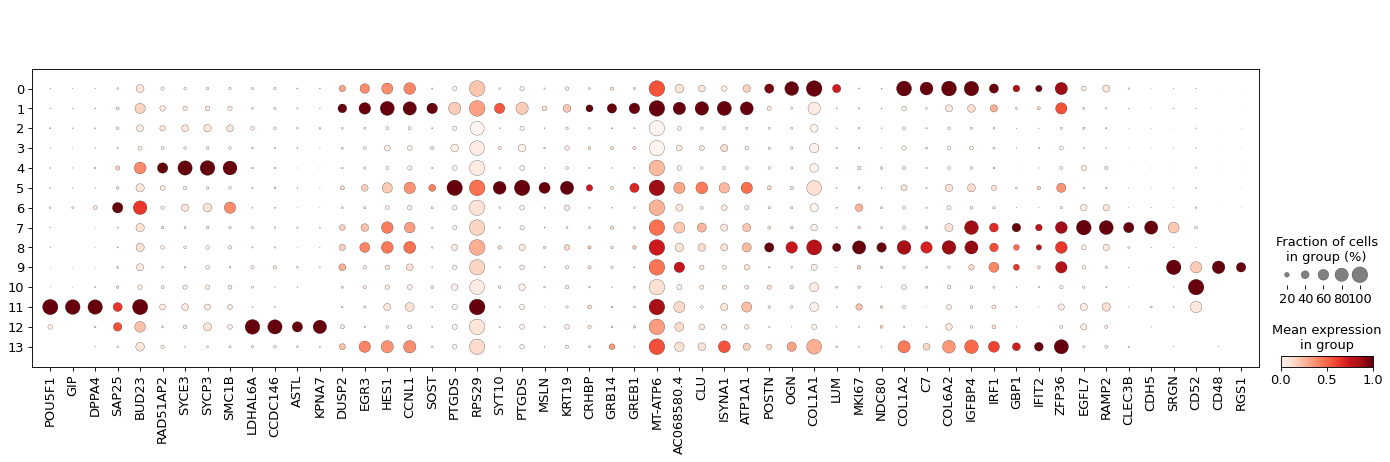

In [20]:
sc.pl.dotplot(adata, var_names = top_markers, groupby = 'leiden', standard_scale = 'var')

In [7]:
mouse_markers = [ 'POU5F1', 'DDX4',
 'DAZL',  'STRA8',  'SYCE3', 'ZAR1', 'KRT19', 'MSLN', 
                 'KITLG', 'WNT6', 'WNT4', 'FOXL2',
 
              
 'NR2F2',
 'COL1A1',
 'DCN','CDH5','TYROBP',
 'CD52', 
 
 ]

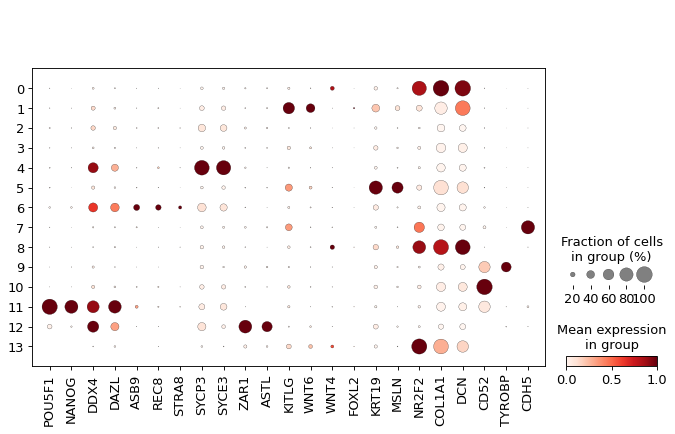

In [104]:
sc.pl.dotplot(adata, var_names = mouse_markers, groupby = 'leiden', standard_scale = 'var')

 * Clusters 2, 3 have very low genes detected (see violin plot) and have no markers --> 10 is erythroid cells
 * Clusters 4, 6, 11, 12 are germ cells 
 * Clusters 1 are supporting cells
 * Cluster 5 are mesothelial cells 
 * Clusters 0, 8, 13 are mesenchymal cells 
 * Cluster 7 are endothelial cells 
 * Cluster 9 are macrophages 


In [3]:
cell_types = {'4' : 'Germ cells', '6' : 'Germ cells', '11' : 'Germ cells', '12' : 'Germ cells',
              '1' : 'Supporting', '5' : 'Mesothelial',
              '0' : 'Mesenchymal', '8' : 'Mesenchymal', '13' : 'Mesenchymal',  '7' : 'Endothelial', 
             '9' : 'Myeloid', '2' : 'lowQC', '3' : 'lowQC', '10' : 'Erythroid'}
adata.obs['cell_type'] = adata.obs['leiden'].map(cell_types)
adata.obs['cell_type'].value_counts(dropna = False)

Mesenchymal    3840
lowQC          2566
Germ cells     2240
Supporting     1995
Mesothelial     986
Endothelial     320
Myeloid         188
Erythroid       173
Name: cell_type, dtype: int64

... storing 'cell_type' as categorical


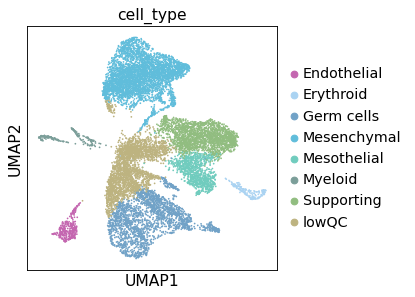

In [4]:
sc.pl.umap(adata, color = ['cell_type'])

In [6]:
adata.obs['cell_type'] = adata.obs['cell_type'].cat.reorder_categories(['Germ cells',
                                                                        'Mesothelial', 'Supporting', 'Mesenchymal', 
                                                                         
                                                                        'Endothelial', 'Myeloid', 'Erythroid','lowQC'])

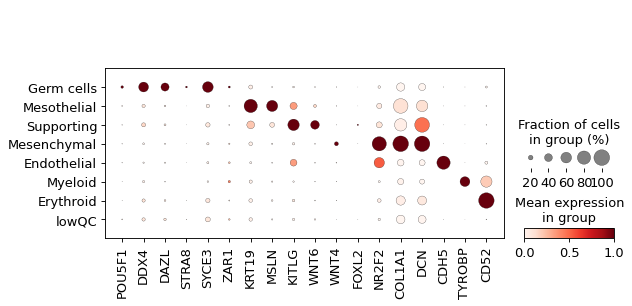

In [8]:
sc.pl.dotplot(adata, var_names = mouse_markers, groupby = 'cell_type', standard_scale = 'var', 
             save = '_monkey_markers')

In [4]:
#### Gonads colors 
gonads_colors = ['#ff0000',  # germs
                  '#366b36', # sup
                  '#d9439a', # preGC
                  '#fcbdc4', # Gi and Oi
                  '#e36a1e',  '#ffb485', '#ffd919', '#c4c4c2']

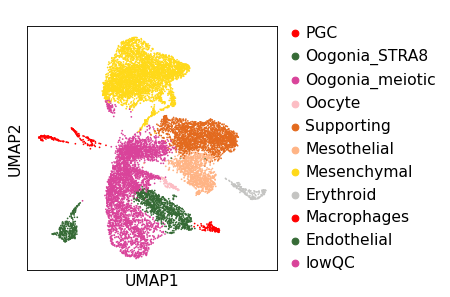

In [5]:
sc.pl.umap(adata, color = ['cell_type'], palette = gonads_colors,  frameon = True, title = " ",
           legend_fontsize = "medium", legend_fontweight = 'medium', save = '_celltype')

In [12]:
stage_gradient = ['#77A8C3', '#C5DAE5']

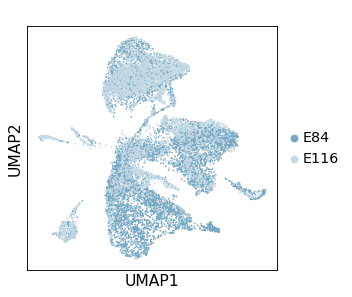

In [13]:
sc.pl.umap(adata, color = 'stage', palette = stage_gradient, save = "_stage_all", title = " ")

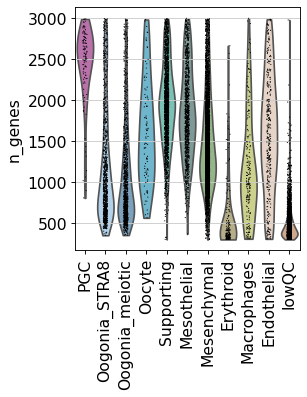

In [10]:
sc.pl.violin(adata, keys = ['n_genes'], groupby = 'cell_type', rotation = 90, save = '_ngenes.pdf')

In [11]:
adata.shape

(12308, 15078)

In [12]:
adata.obs['cell_type'].value_counts()

Mesenchymal        3840
lowQC              2566
Supporting         1995
Oogonia_meiotic    1085
Mesothelial         986
Oogonia_STRA8       949
Endothelial         320
Macrophages         188
Erythroid           173
PGC                 111
Oocyte               95
Name: cell_type, dtype: int64

#### Save object

In [13]:
adata.write('/nfs/team292/vl6/Monkey_Zhao/preprocessing_postDoublets_filtered.h5ad')

In [3]:
adata = sc.read('/nfs/team292/vl6/Monkey_Zhao/preprocessing_postDoublets_filtered.h5ad')

#### Select supporting & mesothelial cells

In [60]:
supp_meso = adata[[i in ['Supporting', 'Mesothelial'] for i in adata.obs['cell_type']]]
print(supp_meso.shape)
supp_meso.write("/nfs/team292/vl6/Monkey_Zhao/supporting_mesothelial.h5ad")

/home/jovyan/my-conda-envs/scanpy_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(2981, 15078)


In [14]:
germcells = adata[[i in ['Oogonia_meiotic', 'Oogonia_STRA8', 'PGC', 'Oocyte'] for i in adata.obs['cell_type']]]
print(germcells.shape)
germcells.write("/nfs/team292/vl6/Monkey_Zhao/germcells.h5ad")

/home/jovyan/my-conda-envs/scanpy_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(2240, 15078)


#### TF-IDF 

In [6]:
import rpy2.rinterface_lib.callbacks
import logging
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [7]:
import anndata
adata = anndata.AnnData(X = adata.raw.X, var = adata.raw.var, obs = adata.obs)

In [8]:
%%R -i adata
adata

class: SingleCellExperiment 
dim: 15078 12308 
metadata(0):
assays(1): X
rownames(15078): PGBD2 ZNF692 ... C11orf86 CX3CL1
rowData names(5): monkey_ENSEMBL human_ENSEMBL human_gene_ortholog
  monkey_gene_name n_cells
colnames(12308): AAACCCAAGTCAGCCC_1 AAACCCAAGTGCTACT_1 ...
  TTTGTTGTCGGTAGAG_2 TTTGTTGTCTACTCAT_2
colData names(11): stage percent_mito ... leiden cell_type
reducedDimNames(0):
altExpNames(0):


In [9]:
%%R -o mrks

library(SoupX)
counts <- assay(adata, "X")
colnames(counts) <- colnames(adata)
rownames(counts) <- rownames(adata)
mrks = quickMarkers(counts, colData(adata)$cell_type, N = 100) # where clusters is the cell type assignment and 20 means I want the top 20 genes per cluster that pass the hypergeometric test

In [10]:
mrks

,gene,cluster,geneFrequency,geneFrequencyOutsideCluster,geneFrequencySecondBest,geneFrequencyGlobal,secondBestClusterName,tfidf,idf,qval
1,GIP,PGC,0.918919,0.014020,0.060063,0.022181,Oogonia_STRA8,3.499733,3.808533,6.981374e-162
2,POU5F1,PGC,0.963964,0.021153,0.200000,0.029656,Oocyte,3.391329,3.518107,6.505843e-161
3,NANOG,PGC,0.783784,0.010412,0.050580,0.017387,Oogonia_STRA8,3.175914,4.052029,7.315517e-135
4,DPEP2,PGC,0.756757,0.009347,0.063830,0.016087,Macrophages,3.125207,4.129738,3.152565e-131
5,TRIML2,PGC,0.837838,0.017299,0.082192,0.024699,Oogonia_STRA8,3.100819,3.700977,4.383423e-133
...,...,...,...,...,...,...,...,...,...,...
997,LPAR6,Endothelial,0.250000,0.005255,0.021277,0.011618,Macrophages,1.113790,4.455160,5.950283e-89
998,C1QTNF5,Endothelial,0.481250,0.088672,0.178125,0.098879,Mesenchymal,1.113545,2.313861,4.281796e-69
999,FAM171A1,Endothelial,0.471875,0.084585,0.160243,0.094654,Mesothelial,1.112459,2.357528,6.664906e-69
1000,RGCC,Endothelial,0.409375,0.058225,0.505319,0.067355,Macrophages,1.104406,2.697785,1.046924e-68


In [11]:
mrks.to_csv("/home/jovyan/Monkey_markersTFIDF.csv")